# FA691 Homework 4
# Due: Wednesday, February 22 @ 11:59PM

Name: Ryan Shea

Date: 2022-12-21

In [1]:
import numpy as np
import yfinance
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pandas as pd
import tensorflow as tf

# Set seed of random number generator
CWID = 10445281 #Place here your Campus wide ID number, this will personalize
#your results, but still maintain the reproduceable nature of using seeds.
#If you ever need to reset the seed in this assignment, use this as your seed
#Papers that use -1 as this CWID variable will earn 0's so make sure you change
#this value before you submit your work.
personal = CWID % 10000
np.random.seed(personal)
tf.random.set_seed(personal)

2023-02-22 22:32:39.362265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Question 1 (5pt)

### Question 1.1
Use the `yfinance` package (or other method of your choice) to obtain the daily adjusted close prices for `SPY` and `IEF`.  You should have at least 5 years of data for both assets. Do **not** include any data after January 1, 2022.  You should inspect the dates for your data to make sure you are including everything appropriately.  Create a binary variable whether the `SPY` returns are above the `IEF` returns on a each day. Create a data frame (or array) of the daily log returns both both stocks along with the lagged returns (at least 2 lags) and your binary class variable.  Use the `print` command to display your data.

In [2]:
stop = date(2021, 12, 31)
start = stop - timedelta(days=365*5 + 50) # 5 years, 50 day buffer
tickers = ['SPY', 'IEF']
data = yfinance.download(tickers, start, stop)['Adj Close']
ret = data.apply(lambda x: np.log(x / x.shift(1))) # log returns
ret['SPY_ABOVE_IEF'] = (ret['SPY'] > ret['IEF']) + 0

lags = 2
for t in tickers:
    for l in range(1, lags + 1):
        ret[f'{t}_LAG_{l}'] = ret[t].shift(l)    
ret = ret.dropna()
ret

[*********************100%***********************]  2 of 2 completed


,IEF,SPY,SPY_ABOVE_IEF,SPY_LAG_1,SPY_LAG_2,IEF_LAG_1,IEF_LAG_2
Date,,,,,,,
2016-11-17,-0.004419,0.005128,1,-0.001880,0.007772,0.000938,0.000000
2016-11-18,-0.004438,-0.002240,1,0.005128,-0.001880,-0.004419,0.000938
2016-11-21,0.000851,0.007523,1,-0.002240,0.005128,-0.004438,-0.004419
2016-11-22,0.000946,0.001951,1,0.007523,-0.002240,0.000851,-0.004438
2016-11-23,-0.003597,0.000544,1,0.001951,0.007523,0.000946,0.000851
...,...,...,...,...,...,...,...
2021-12-23,-0.002079,0.006203,1,0.009949,0.017603,0.000952,-0.003977
2021-12-27,0.000347,0.014053,1,0.006203,0.009949,-0.002079,0.000952
2021-12-28,-0.000173,-0.000818,0,0.014053,0.006203,0.000347,-0.002079


### Question 1.2
Split your data into training and testing sets (80% training and 20% test). This split should be done so that the causal relationship is kept consistent (i.e., split data at a specific time).

Run a logistic regression of the binary variable (of `SPY` returns greater than `IEF` returns) as a function of the lagged returns (at least 2 lags) for both stocks.
This should be of the form (assuming 2 lags) of $p_{t} = [1 + \exp(-[\beta_0 + \beta_{SPY,1} r_{SPY,t-1} + \beta_{SPY,2} r_{SPY,t-2} + \beta_{IEF,1} r_{IEF,t-1} + \beta_{IEF,2} r_{IEF,t-2}])]^{-1}$.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [3]:
# use the last year as testing as that would be roughly an 80-20 split
train = ret[ret.index <= '2021-01-01']
test = ret[ret.index > '2021-01-01']
print(f'Training set shape: {train.shape}')
print(f'Testing set shape:  {test.shape}')
print(f"Ratio:              {train.shape[0] / ret.shape[0]:.2f}")

X_train, y_train = train.drop(['SPY_ABOVE_IEF', 'SPY', 'IEF'], axis=1), train['SPY_ABOVE_IEF']
X_test, y_test = test.drop(['SPY_ABOVE_IEF', 'SPY', 'IEF'], axis=1), test['SPY_ABOVE_IEF']

Training set shape: (1037, 7)
Testing set shape:  (251, 7)
Ratio:              0.81


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

log = LogisticRegression()
log.fit(X_train, y_train)
log_pred = log.predict(X_test)


print(f'Accuracy: {accuracy_score(y_test, log_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, log_pred)}', end='\n\n')

print(f'Average confidence in prediction: {log.predict_proba(X_test)[:, 1].mean()}')
print(f'Average Standard Deviation:       {log.predict_proba(X_test)[:, 1].std()}')

print(f'Actual ratio of SPY > IEF:        {y_test.mean()}')

Accuracy: 0.5776892430278885
Confusion Matrix:
[[  0 106]
 [  0 145]]

Average confidence in prediction: 0.5515638826393182
Average Standard Deviation:       0.0009051530328767887
Actual ratio of SPY > IEF:        0.5776892430278885


I wanted to dig in a little further to see how the model was actually making the predictions as it is just predicting `SPY > IEF` every time. You can see that the actual ratio is the exact same as the accuracy score since it is always making the same prediction. I dug into the predict probabilities and found out that it has a predict probability of `SPY > IEF` of around 0.55, with a neglegible standard deviation. The model has realistically no ability to predict the direction of the market and is just guessing whichever direction has more data. It is implying that a linear approcach has too high of a bias and is not able to capture the non-linear relationship between the data.

## Question 2 (20pt)

### Question 2.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a (plain) recurrent neural network of your own design using a time step of 2.
You may choose any activation functions you wish.

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score

num_features = X_train.shape[1]

rnn = Sequential()
rnn.add(Reshape((2, 2), input_shape=(num_features,)))
rnn.add(SimpleRNN(16, return_sequences=True, activation='relu'))
rnn.add(SimpleRNN(32, activation='relu'))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

rnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 2)              0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 2, 16)             304       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________


2023-02-22 22:32:43.753657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Question 2.2
Train this neural network on the training data.  
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

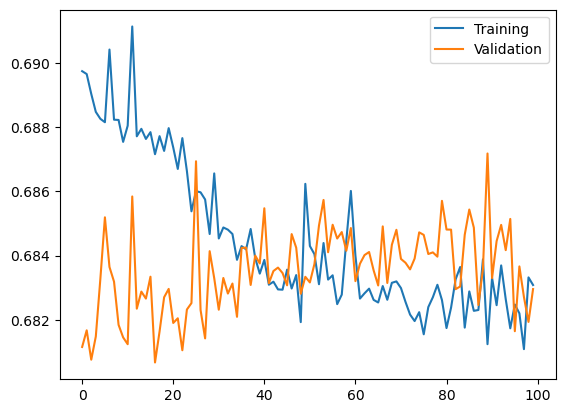

Training Accuracy: 0.5551983118057251
Validation Accuracy: 0.5769230723381042

Test Accuracy: 0.5776892430278885
Confusion Matrix:
[[  0 106]
 [  0 145]]



In [6]:
rnn.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])
history = rnn.fit(X_train, y_train, epochs=100, validation_split = 0.1, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.show()
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}", end="\n\n")

rnn_pred = rnn.predict(X_test, verbose=0)
rnn_pred = (rnn_pred > 0.5) + 0
print(f'Test Accuracy: {accuracy_score(y_test, rnn_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, rnn_pred)}', end='\n\n')

The Simple RNN is also always predicting `SPY` to outperform `IEF` no matter what. This is somewhat surprising as I would have thought that the increased complexity in the model would have allowed it to capture the non-linear relationship between the data.

## Question 3 (20pt)

### Question 3.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a long short-term memory (LSTM) network of your own design using a time step of 2.
You may choose any activation functions you wish.

In order to see if I can get the model to predict more than just `SPY` outperforming `IEF` I am going to make a very complex model. This way it should be able to find some sort of "guess", even if it is overfitting, I would like to see a different result in the confusion matrix.

In [7]:
from keras.layers import LSTM

lstm = Sequential()
lstm.add(Reshape((2, 2), input_shape=(num_features,)))
lstm.add(LSTM(16, return_sequences=True, activation='relu'))
lstm.add(LSTM(32, activation='tanh'))
lstm.add(Dense(128, activation='tanh'))
lstm.add(Dense(512, activation='relu'))
lstm.add(Dense(1024, activation='tanh'))
lstm.add(Dense(16, activation='relu'))
lstm.add(Dense(16, activation='relu'))
lstm.add(Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 2, 2)              0         
                                                                 
 lstm (LSTM)                 (None, 2, 16)             1216      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 16)               

### Question 3.2
Train this neural network on the training data.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

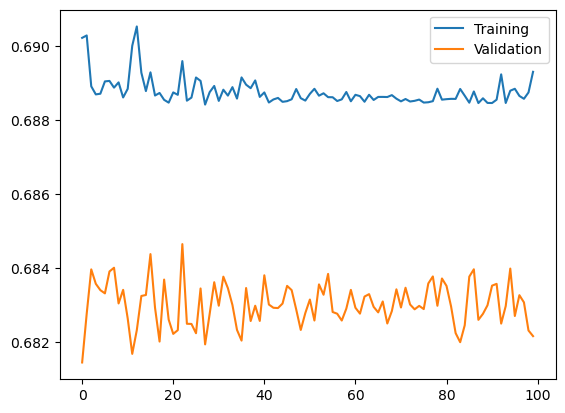

Training Accuracy: 0.5487673878669739
Validation Accuracy: 0.5769230723381042

Test Accuracy: 0.5776892430278885
Confusion Matrix:
[[  0 106]
 [  0 145]]



In [8]:
lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = lstm.fit(X_train, y_train, epochs=100, validation_split = 0.1, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.show()
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}", end="\n\n")

lstm_pred = lstm.predict(X_test, verbose=0)
lstm_pred = (lstm_pred > 0.5) + 0
print(f'Test Accuracy: {accuracy_score(y_test, lstm_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, lstm_pred)}', end='\n\n')

Interestingly enough, with almost 620,000 trainable parameters, the LSTM is *still* predicting `SPY` to outperform `IEF` every time. This is very surprising to me. This leads me to believe that 2 lags for each is simply not enough to capture the relationship between the data. It might be too random, so I will try to add more lags in order to see if I can get a different result.

In [9]:
stop = date(2021, 12, 31)
start = stop - timedelta(days=365*5 + 50) # 5 years, 50 day buffer
tickers = ['SPY', 'IEF']
data = yfinance.download(tickers, start, stop)['Adj Close']
ret = data.apply(lambda x: np.log(x / x.shift(1))) # log returns
ret['SPY_ABOVE_IEF'] = (ret['SPY'] > ret['IEF']) + 0

lags = 10
for t in tickers:
    for l in range(1, lags + 1):
        ret[f'{t}_LAG_{l}'] = ret[t].shift(l)    
ret = ret.dropna()

train = ret[ret.index <= '2021-01-01']
test = ret[ret.index > '2021-01-01']


X_train, y_train = train.drop(['SPY_ABOVE_IEF', 'SPY', 'IEF'], axis=1), train['SPY_ABOVE_IEF']
X_test, y_test = test.drop(['SPY_ABOVE_IEF', 'SPY', 'IEF'], axis=1), test['SPY_ABOVE_IEF']

num_features = X_train.shape[1]

[*********************100%***********************]  2 of 2 completed


In [10]:
lstm2 = Sequential()
lstm2.add(Reshape((2, 10), input_shape=(num_features,)))
lstm2.add(LSTM(16, return_sequences=True, activation='relu'))
lstm2.add(LSTM(32, activation='tanh'))
lstm2.add(Dense(128, activation='tanh'))
lstm2.add(Dense(16, activation='relu'))
lstm2.add(Dense(1, activation='sigmoid'))
lstm2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 2, 10)             0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 16)             1728      
                                                                 
 lstm_3 (LSTM)               (None, 32)                6272      
                                                                 
 dense_8 (Dense)             (None, 128)               4224      
                                                                 
 dense_9 (Dense)             (None, 16)                2064      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 14,305
Trainable params: 14,305
Non-trai

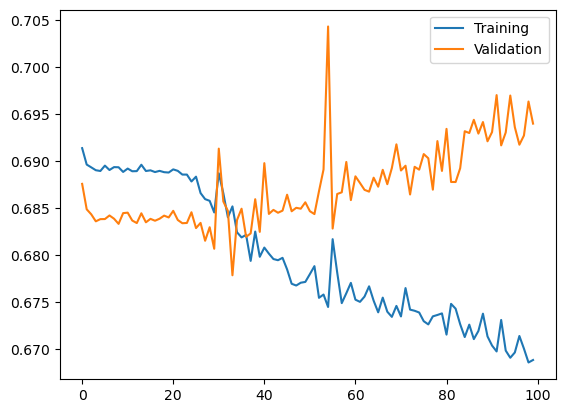

Training Accuracy: 0.5691144466400146
Validation Accuracy: 0.5436893105506897

Test Accuracy: 0.5737051792828686
Confusion Matrix:
[[  1 105]
 [  2 143]]



In [11]:
lstm2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = lstm2.fit(X_train, y_train, epochs=100, validation_split = 0.1, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.show()
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}", end="\n\n")

lstm2_pred = lstm2.predict(X_test, verbose=0)
lstm2_pred = (lstm2_pred > 0.5) + 0
print(f'Test Accuracy: {accuracy_score(y_test, lstm2_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, lstm2_pred)}', end='\n\n')

Even with 10 lags each, the LSTM model is still almost only predicting `SPY` to outperform `IEF` every time. At this point I am confused as to why this is happening.

## Question 4 (20pt)

## Question 4.1
Consider the same classification problem as in Question 1.2.
Of the methods considered in this assignment, which would you recommend in practice?
Explain briefly (1 paragraph) why you choose this fit. 

Out of any of the methods, realistically *none* of them seem to be useful. They are all literally doing the same thing, predicting `SPY` to outperform `IEF` every time. I am actually perplexed as I have tried to add more lags, more neurons, more layers, and nothing seems to be working. I did not have this problem in the past assignment and I do not understand why the recurrent neural networks do not seem to capture any meaningful information from the data. There is realistically no reason to use any model, just to use whatever your risk tolerance is. If it is higher, invest in `SPY`: if it is lower, invest in `IEF`.

## Question 4.2
Recreate your data set using data from January 1, 2022 through December 31, 2022.
Using the method your would implement in practice, invest in the asset (``SPY`` or ``IEF``) depending on your predictions.
Print the returns your portfolio would obtain from following this strategy. Comment on how this portfolio compares with the ``SPY`` and ``IEF`` returns and risks.

As there were no meaningful results from the models, I am just going to compare the difference in `SPY` and `IEF` returns and arbitrarily pick the simple RNN. I will find the annualized mean, standard deviation, sharpe ratio and compare the cumulative returns. 

[*********************100%***********************]  2 of 2 completed
Cumulative Returns:
IEF   -0.150248
SPY   -0.186641
RNN   -0.187360
Name: 2022-12-30 00:00:00, dtype: float64

Standard Deviation:
IEF    0.102114
SPY    0.243246
RNN    0.241862
dtype: float64

Sharpe Ratio:
IEF   -1.495099
SPY   -0.779671
RNN   -0.787154
dtype: float64


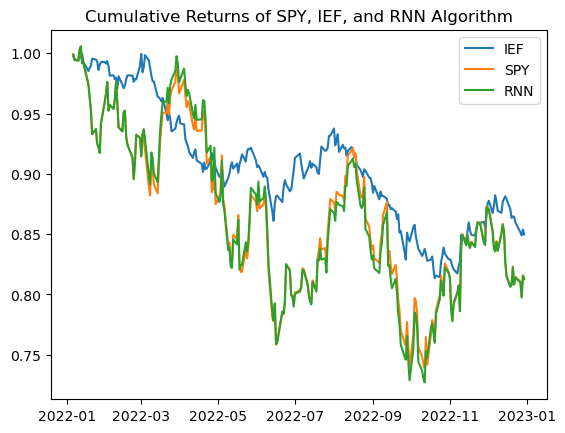

In [12]:
data = yfinance.download(tickers, '2022-01-01', '2022-12-31')['Adj Close'].apply(lambda x: np.log(x / x.shift(1)))

lags = 2
X = pd.DataFrame()
for t in tickers:
    for l in range(1, lags + 1):
        X[f'{t}_LAG_{l}'] = data[t].shift(l)

X = X.dropna()

data = data.loc[X.index] # align data with X


rnn_pred = rnn.predict(X, verbose=0)
rnn_pred = ((rnn_pred > 0.5) + 0).flatten()

data['RNN'] = np.where(rnn_pred == 1, data['SPY'], data['IEF']) # RNN model predictions

cum_return = data.cumsum()

print("Cumulative Returns:\n", cum_return.iloc[-1], sep='', end='\n\n')

sd = data.std() * np.sqrt(252)
print("Standard Deviation:\n", sd, sep='', end='\n\n')

sharpe = (data.mean() * 252) / sd
print("Sharpe Ratio:\n", sharpe, sep='')

plt.plot(1+cum_return)
plt.legend(cum_return.columns)
plt.title('Cumulative Returns of SPY, IEF, and RNN Algorithm')
plt.show()


It really just comes down to whatever your individual risk tolerance is. You can see that the `SPY` performed worse in terms of general returns but had a higher sharpe ratio. It was also over a terrible year for the market in general so it is not surprising that `SPY` underperformed. It's interesting that the RNN model began to diverge from `SPY`, as it seems to be making slightly different predictions now.